In [1]:
from imports import *

# set columnns display format
pd.set_option('display.max_columns', None)
# default pandas decimal number display format
pd.options.display.float_format = '{:20,.3f}'.format

# Data Acquisition

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def new_zillow_data():
    '''
    This function reads the Zillow data from the mySQL database into a df.
    '''
    # Create SQL query.
    sql_query = '''
    SELECT 
    prop.*,
    pred.logerror,
    pred.transactiondate,
    air.airconditioningdesc,
    arch.architecturalstyledesc,
    build.buildingclassdesc,
    heat.heatingorsystemdesc,
    landuse.propertylandusedesc,
    story.storydesc,
    construct.typeconstructiondesc
FROM
    properties_2017 prop
        INNER JOIN
    (SELECT 
        parcelid, logerror, MAX(transactiondate) AS transactiondate
    FROM
        predictions_2017
    GROUP BY parcelid ,  logerror) pred USING (parcelid)
        LEFT JOIN
    airconditioningtype air USING (airconditioningtypeid)
        LEFT JOIN
    architecturalstyletype arch USING (architecturalstyletypeid)
        LEFT JOIN
    buildingclasstype build USING (buildingclasstypeid)
        LEFT JOIN
    heatingorsystemtype heat USING (heatingorsystemtypeid)
        LEFT JOIN
    propertylandusetype landuse USING (propertylandusetypeid)
        LEFT JOIN
    storytype story USING (storytypeid)
        LEFT JOIN
    typeconstructiontype construct USING (typeconstructiontypeid)
WHERE prop.propertylandusetypeid = 261 AND
        prop.latitude IS NOT NULL
        AND prop.longitude IS NOT NULL
        AND transactiondate <= '2017-12-31';
    '''
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    return df

def get_zillow_data():
    '''
    This function reads in zillow data from Zillow database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow_data.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('zillow_data.csv', index_col=0)
    else:
        
        # Read fresh data from db into a DataFrame.
        df = new_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow_data.csv')
        
    return df

In [4]:
df = get_zillow_data()

In [5]:
df.shape

(52438, 67)

# Data Preparation

### 1. Missing Values

In [6]:
def handle_missing_values(df, prop_required_columns, prop_required_row):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold) #1, or ‘columns’ : Drop columns which contain missing value
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold) #0, or ‘index’ : Drop rows which contain missing values.
    return df

In [7]:
df = handle_missing_values(df, 0.75, 0.75)

In [8]:
df.shape

(52434, 28)

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
propertylandusedesc             0
dtype: int64

In [11]:
df.shape

(50670, 28)

In [12]:
(52434-50670)/52434

0.03364229316855476

We feel comfortable dropping nulls because it's only 3.4% of the data.

### 2. Rename Columns

In [13]:
df.rename(columns = {'bathroomcnt':'bathrooms', 'bedroomcnt':'bedrooms',
                              'calculatedfinishedsquarefeet':'total_sqft', 'finishedsquarefeet12': 'living_sqft', 'fullbathcnt':'full_bath', 'lotsizesquarefeet':'lot_sqft', 'regionidcity':'city', 'regionidzip':'zips', 'structuretaxvaluedollarcnt': 'structure_value', 'taxvaluedollarcnt':'assessed_value', 'landtaxvaluedollarcnt':'land_value'}, inplace = True)

In [14]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'calculatedbathnbr', 'total_sqft',
       'living_sqft', 'fips', 'full_bath', 'latitude', 'longitude', 'lot_sqft',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'city', 'regionidcounty', 'zips', 'roomcnt',
       'yearbuilt', 'structure_value', 'assessed_value', 'assessmentyear',
       'land_value', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc'],
      dtype='object')

### 3. Data Mapping, Dummy Variables

In [15]:
df['age'] = 2017 - df['yearbuilt']

In [16]:
df['county'] = df.fips.map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

### 4. Impute Latitude & Longitude

In [17]:
df.latitude = df.latitude/1000000

In [18]:
df.longitude = df.longitude/1000000

### 5. Drop Unuseful Columns

In [19]:
col = ['parcelid','assessmentyear','yearbuilt','fips','propertycountylandusecode', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcounty', 'propertylandusedesc']
df.drop(columns = col, inplace = True)

### 6. Drop incorrect zip codes

In [26]:
df.zips.min()

95982

### 7. Data Types

In [20]:
df.dtypes

bathrooms            float64
bedrooms             float64
calculatedbathnbr    float64
total_sqft           float64
living_sqft          float64
full_bath            float64
latitude             float64
longitude            float64
lot_sqft             float64
city                 float64
zips                 float64
roomcnt              float64
structure_value      float64
assessed_value       float64
assessmentyear       float64
land_value           float64
taxamount            float64
logerror             float64
transactiondate       object
age                  float64
county                object
dtype: object

In [21]:
df['city'] = df['city'].astype(int)

In [23]:
df['zips'] = df['zips'].astype(int)

In [24]:
df['age'] = df['age'].astype(int)

### 8. Outliers

#### Distribution of `bathroomcnt`, `bedroomcnt`, `calculatedbathnbr`, `calculatedfinishedsquarefeet`, `fullbathcnt`

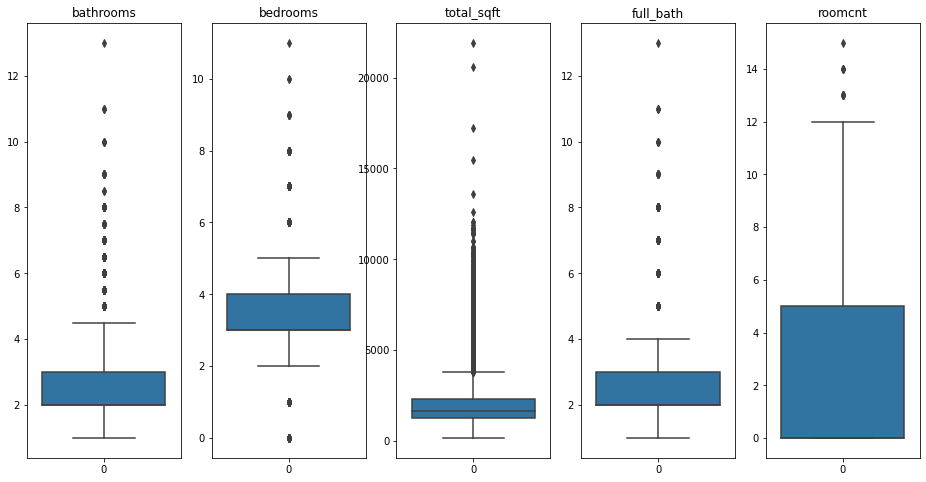

In [36]:
plt.figure(figsize = (16,8))

# List of columns
cols = ['bathrooms', 'bedrooms', 'total_sqft', 'full_bath', 'roomcnt']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,5, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    sns.boxplot(data = df[col])

In [34]:
# bedrooms

q1, q3 = df.bedrooms.quantile([.25, 0.75])
iqr = q3 - q1
k = 2
upper_bound= q3 + k * iqr
upper_bound

6.0

In [33]:
# bathrooms

q1, q3 = df.bathrooms.quantile([.25, 0.75])
iqr = q3 - q1
k = 3
upper_bound= q3 + k * iqr
upper_bound

6.0

In [37]:
# total_sqft

q1, q3 = df.total_sqft.quantile([.25, 0.75])
iqr = q3 - q1
k = 3
upper_bound= q3 + k * iqr
upper_bound

5340.0

In [39]:
# lot_sqft

q1, q3 = df.lot_sqft.quantile([.25, 0.75])
iqr = q3 - q1
k = 10
upper_bound= q3 + k * iqr
upper_bound

40487.5

#### Distribution of `assessed_value`, `structure_value`, `land_value`

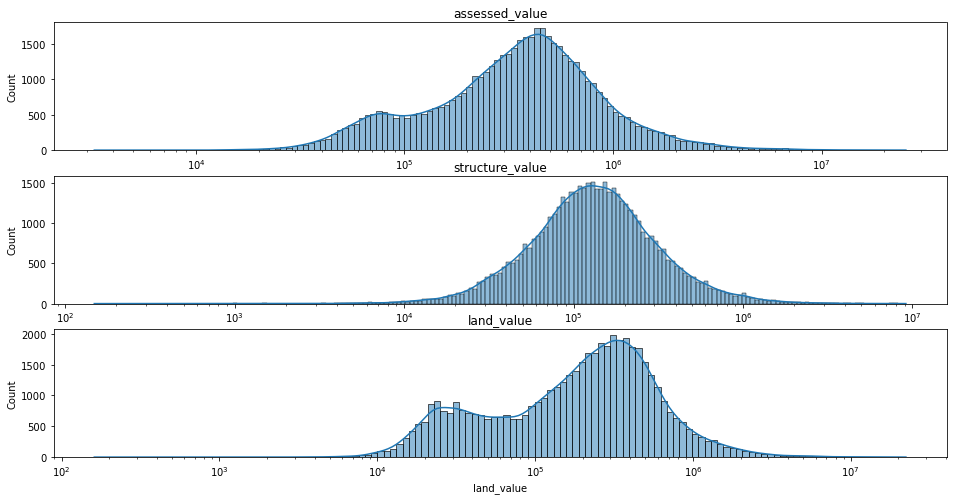

In [40]:
plt.figure(figsize = (16,8))

# List of columns
cols = ['assessed_value', 'structure_value', 'land_value']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(3,1, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    sns.histplot(data=df, x=col, kde=True, log_scale=True)

In [45]:
# lot_sqft

q1, q3 = df.assessed_value.quantile([.25, 0.75])
iqr = q3 - q1
k = 1.1
upper_bound= q3 + k * iqr
upper_bound

1071103.6

### 9. Split Data

In [ ]:
def split(df):
    '''
    This function drops the customer_id column and then splits a dataframe into 
    train, validate, and test in order to explore the data and to create and validate models. 
    It takes in a dataframe and contains an integer for setting a seed for replication. 
    Test is 20% of the original dataset. The remaining 80% of the dataset is 
    divided between valiidate and train, with validate being .30*.80= 24% of 
    the original dataset, and train being .70*.80= 56% of the original dataset. 
    The function returns, train, validate and test dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123)   
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test